<a href="https://colab.research.google.com/github/cooolbabu/GoogleGemini101/blob/main/OpenAI/2_LangChain_SQL_Queries_DatabaseAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build your First SQL Database Agent with LangChain
[Lawrence Knight](https://medium.com/@LawrencewleKnight/build-your-first-sql-database-agent-with-langchain-19af8064ae18)

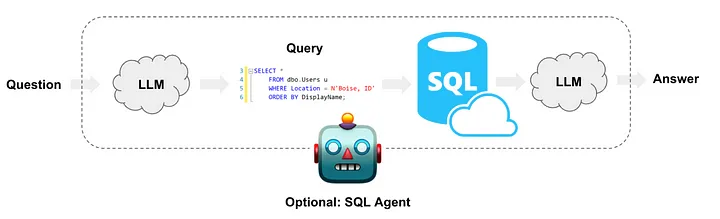

## Installation


In [1]:
!pip install openai langchain langchain_experimental langchain-openai -q
!pip install langchain-anthropic -q
!pip install supabase -q
!pip install pyodbc -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.8/276.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Get API Keys and setup

In [2]:
## There are other versions. At somepoint get a handle on the differences
# from langchain.llms import OpenAI
# from langchain.agents import create_sql_agent
# from langchain.agents.agent_types import AgentType
# from langchain.agents.agent_toolkits import SQLDatabaseToolkit
# from langchain.utilities import SQLDatabase


from langchain.agents import create_sql_agent
from langchain.agents.agent_types import AgentType
from langchain.sql_database import SQLDatabase

from langchain_openai import OpenAI
from langchain_anthropic import ChatAnthropic

from langchain_experimental.sql import SQLDatabaseChain
from langchain_community.agent_toolkits import SQLDatabaseToolkit

from supabase import create_client, Client

from sqlalchemy import create_engine

import pandas as pd
import pyodbc

from google.colab import userdata

# setup supabase
supabase_url = userdata.get('SUPABASE_URL')
supabase_key = userdata.get('SUPABASE_KEY')
supabase_client = create_client(supabase_url, supabase_key)

# OpenAI key
openai_api_key = userdata.get('OPENAI_API_KEY')

In [3]:
# Test connection to Supabase using Supabase client

# There are 59 records. Displaying the first 3

response = supabase_client.table('Customer').select("*").execute()

## response object has data attribute that contains the result
## response.data
response_df = pd.DataFrame(response.data)
response_df.head(3)


,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
2,3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3


In [4]:
# Connecting to Supabase using SQL Alchemy

# Make sure the connection string is a proper string within quotes
supabase_conn_str = userdata.get('supabase_conn_str')
#supabase_conn_str = "postgresql+psycopg2://[USERID:PASSWORD]@[HOSTNAME:PORT_NUMBER]/[DATABASE_NAME]"


# Use the connection string with SQLAlchemy's create_engine function
db_engine = create_engine(supabase_conn_str)
db = SQLDatabase(db_engine)

# test the connection
print(db.dialect)
print(db.get_usable_table_names())


postgresql
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track', 'countries']


## Lets run some chains

In [5]:


#llm = OpenAI(temperature=0, verbose=True, api_key=openai_api_key, model="gpt-3.5-turbo-0125")
#llm = OpenAI(api_key=openai_api_key)

llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=0, max_tokens=1024, anthropic_api_key= userdata.get('Claude_api_key'))


In [6]:
db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True)

In [7]:
# db_chain.run("How many employees are there?") # Run is being deprecated at 0.2
emp_count = db_chain.invoke("How many employees are there?")




> Entering new SQLDatabaseChain chain...
How many employees are there?
SQLQuery:SQLQuery:
SELECT COUNT(*) AS "Number of Employees"
FROM "Employee";
SQLResult: [(8,)]
Answer:There are 8 employees.
> Finished chain.


In [8]:
emp_count

{'query': 'How many employees are there?', 'result': 'There are 8 employees.'}

## Create an Agent

In [9]:
agent_executor = create_sql_agent(
    llm=llm,
    toolkit=SQLDatabaseToolkit(db=db, llm=llm),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

In [10]:
response = agent_executor.invoke(
    "How many employees are there?"
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new SQL Agent Executor chain...
Thought: To find out how many employees there are, I need to query the employees table and count the number of rows.

Action: sql_db_list_tables
Action Input: 
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track, countriesThought: The employees table exists in the database, so I can query it to count the number of rows.

Action: sql_db_query_checker
Action Input: SELECT COUNT(*) FROM Employee;
SELECT COUNT(*) FROM Employee;Thought: The query looks correct, so I can execute it to get the number of employees.

Action: sql_db_query
Action Input: SELECT COUNT(*) FROM Employee;
Error: (psycopg2.errors.UndefinedTable) relation "employee" does not exist
LINE 1: SELECT COUNT(*) FROM Employee;
                             ^

[SQL: SELECT COUNT(*) FROM Employee;
]
(Background on this error at: https://sqlalche.me/e/20/f405)Thought: The query failed because the table name is likely case-sensitive. I

In [11]:
response

'There are 8 employees.'

In [12]:
from IPython.display import Markdown, display
Markdown(response)

There are 8 employees.

In [14]:
# let's get a description of the playlisttrack table in plain english. Super powerful!
response = agent_executor.run(
    "Describe the playlisttrack table"
)




> Entering new SQL Agent Executor chain...
Thought: To describe the playlisttrack table, I first need to get a list of tables in the database to ensure that the playlisttrack table exists.

Action: sql_db_list_tables
Action Input: 
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track, countriesThought: The playlisttrack table exists in the database, so I can query its schema to describe it.

Action: sql_db_schema
Action Input: PlaylistTrack

CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	CONSTRAINT "PK_PlaylistTrack" PRIMARY KEY ("PlaylistId", "TrackId"), 
	CONSTRAINT "FK_PlaylistTrack_Playlist" FOREIGN KEY("PlaylistId") REFERENCES "Playlist" ("PlaylistId"), 
	CONSTRAINT "FK_PlaylistTrack_Track" FOREIGN KEY("TrackId") REFERENCES "Track" ("TrackId")
)

/*
3 rows from PlaylistTrack table:
PlaylistId	TrackId
1	3402
1	3389
1	3390
*/Thought: I now have enough information to describe the pl

In [16]:
print(type(response))

<class 'str'>


In [15]:
Markdown(response)

The playlisttrack table is a junction table that links playlists to tracks. It has two columns:

PlaylistId (integer) - This is the primary key referencing the PlaylistId column in the Playlist table. It represents the playlist that a track belongs to.

TrackId (integer) - This is the primary key referencing the TrackId column in the Track table. It represents the track that is included in a playlist.

The table has a composite primary key made up of PlaylistId and TrackId columns. It also has two foreign key constraints - one linking to the Playlist table on PlaylistId, and another linking to the Track table on TrackId.

This table allows for a many-to-many relationship between playlists and tracks, where a playlist can contain multiple tracks, and a track can be included in multiple playlists.

In [17]:
## I think the LLM got confused here.
## How do you handle that

response = agent_executor.run(
    "Give me total sales by genre for all genres"
)
print(response)





> Entering new SQL Agent Executor chain...
Thought: To get the total sales by genre, I will need to query the database tables that contain information about sales and genres. First, I should get a list of all tables in the database.

Action: sql_db_list_tables
Action Input: 
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track, countriesThought: The tables that seem relevant are Genre, Invoice, and InvoiceLine. I should check the schema for those tables to see what columns they have and how they relate to each other.

Action: sql_db_schema
Action Input: Genre, Invoice, InvoiceLine

CREATE TABLE "Genre" (
	"GenreId" INTEGER NOT NULL, 
	"Name" VARCHAR(120), 
	CONSTRAINT "PK_Genre" PRIMARY KEY ("GenreId")
)

/*
3 rows from Genre table:
GenreId	Name
1	Rock
2	Jazz
3	Metal
*/


CREATE TABLE "Invoice" (
	"InvoiceId" INTEGER NOT NULL, 
	"CustomerId" INTEGER NOT NULL, 
	"InvoiceDate" TIMESTAMP WITH TIME ZONE NOT NULL, 
	"BillingAddress" VAR

APIStatusError: {'type': 'error', 'error': {'details': None, 'type': 'overloaded_error', 'message': 'Overloaded'}}

In [ ]:
# The answer is false. It still gives only 5. It always sets row count limit to 5 for all queries
# Not sure why it didn't 'pretty print' the SQL code here

with get_openai_callback() as cb:
    result = db_chain.run("Give me total sales in amounts by genre for all genres")
    print(cb)




> Entering new SQLDatabaseChain chain...
Give me total sales in amounts by genre for all genres
SQLQuery:SELECT "Genre"."Name", SUM("InvoiceLine"."UnitPrice" * "InvoiceLine"."Quantity") AS "Total Sales" FROM "Genre" INNER JOIN "Track" ON "Genre"."GenreId" = "Track"."GenreId" INNER JOIN "InvoiceLine" ON "Track"."TrackId" = "InvoiceLine"."TrackId" GROUP BY "Genre"."Name" ORDER BY "Total Sales" DESC LIMIT 5;
SQLResult: [('Rock', Decimal('826.65')), ('Latin', Decimal('382.14')), ('Metal', Decimal('261.36')), ('Alternative & Punk', Decimal('241.56')), ('TV Shows', Decimal('93.53'))]
Answer:The total sales in amounts by genre for all genres are: Rock with $826.65, Latin with $382.14, Metal with $261.36, Alternative & Punk with $241.56, and TV Shows with $93.53.
> Finished chain.
Tokens Used: 5621
	Prompt Tokens: 5482
	Completion Tokens: 139
Successful Requests: 2
Total Cost (USD): $0.008500999999999998


In [ ]:
# And yes. The table has sales going into 2025. That is not an error.
# Convert this text-to-speech and we don't need BI Dashboards.

with get_openai_callback() as cb:
    db_chain.run("Give me total sales by quarter")
    print(cb)




> Entering new SQLDatabaseChain chain...
Give me total sales by quarter
SQLQuery:SELECT SUM("Total") AS "Total Sales", DATE_TRUNC('quarter', "InvoiceDate") AS "Quarter" FROM "Invoice" GROUP BY "Quarter" ORDER BY "Quarter" DESC LIMIT 5
SQLResult: [(Decimal('125.86'), datetime.datetime(2025, 10, 1, 0, 0, tzinfo=datetime.timezone.utc)), (Decimal('112.86'), datetime.datetime(2025, 7, 1, 0, 0, tzinfo=datetime.timezone.utc)), (Decimal('108.90'), datetime.datetime(2025, 4, 1, 0, 0, tzinfo=datetime.timezone.utc)), (Decimal('102.96'), datetime.datetime(2025, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)), (Decimal('117.86'), datetime.datetime(2024, 10, 1, 0, 0, tzinfo=datetime.timezone.utc))]
Answer:The total sales by quarter are 125.86 for the fourth quarter of 2025, 112.86 for the third quarter of 2025, 108.90 for the second quarter of 2025, 102.96 for the first quarter of 2025, and 117.86 for the fourth quarter of 2024.
> Finished chain.
Tokens Used: 5645
	Prompt Tokens: 5532
	Completion Token

## Oops!!! Out of tokens :(

In [ ]:
with get_openai_callback() as cb:
    db_chain.run("Give me total sales by quarter for each genre")
    print(cb)



> Entering new SQLDatabaseChain chain...
Give me total sales by quarter for each genre
SQLQuery:SELECT
    "Genre"."Name" AS "Genre",
    EXTRACT(QUARTER FROM "Invoice"."InvoiceDate") AS "Quarter",
    SUM("InvoiceLine"."UnitPrice" * "InvoiceLine"."Quantity") AS "Total Sales"
FROM "Genre"
INNER JOIN "Track" ON "Genre"."GenreId" = "Track"."GenreId"
INNER JOIN "InvoiceLine" ON "Track"."TrackId" = "InvoiceLine"."TrackId"
INNER JOIN "Invoice" ON "InvoiceLine"."InvoiceId" = "Invoice"."InvoiceId"
GROUP BY "Genre", "Quarter"
ORDER BY "Genre", "Quarter"
SQLResult: [('Alternative', Decimal('1'), Decimal('5.94')), ('Alternative', Decimal('2'), Decimal('3.96')), ('Alternative', Decimal('4'), Decimal('3.96')), ('Alternative & Punk', Decimal('1'), Decimal('60.39')), ('Alternative & Punk', Decimal('2'), Decimal('60.39')), ('Alternative & Punk', Decimal('3'), Decimal('45.54')), ('Alternative & Punk', Decimal('4'), Decimal('75.24')), ('Blues', Decimal('1'), Decimal('15.84')), ('Blues', Decimal('2'),

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 4097 tokens, however you requested 4373 tokens (4117 in your prompt; 256 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}

# So what do you guys's think. What do you think is the toughest query. Post it on the Applied AI Slack channel.